# **Phase 1-2: Image Classification on Pre-trained Models**
```bash
- Name: Nawaraj Rai
- Student ID: 48345148
- Unit: COMP8430
```
# SpillNet – A Deep Learning Framework for Multi-Class Household Spill Classification

## Overview
This project addresses a practical image classification problem: identifying spills frequently encountered in homes and offices is inherently challenging due to the subtle visual differences and similarities between spill types. The goal is to leverage deep learning models—particularly pre-trained CNN architectures—to accurately classify spill images into fine-grained categories such as alcohol, coffee, coke, detergent, and others. Fine-grained classification requires models to capture detailed, distinguishing features, making it an ideal candidate to benchmark the performance of sophisticated convolutional neural network (CNN) architectures.

## Objectives
- **Dataset Collection**: To create a realistic scenario, images were manually captured using an iPhone camera, mimicking real-world conditions such as varied lighting, camera angles, and backgrounds.
- **Pre-trained Model Selection**: Leveraging pre-trained CNN architectures allows us to take advantage of rich feature extraction capabilities learned from large-scale datasets such as ImageNet, significantly reducing training time and enhancing performance.
- **Model Evaluation & Comparison**: By systematically comparing multiple CNN architectures, I aim to identify the most robust model suitable for fine-grained spill classification.

## Dataset Collection and Preparation

### Dataset Overview
Manual dataset collection was specifically chosen to reflect authentic real-world diversity and complexity, significantly impacting model robustness. By capturing multiple spill categories (e.g., coffee, detergent, oil), I created a rich dataset that encompasses variability in color, texture, and surface interactions.

I collected spill images manually using my iPhone camera. Each image represents a spill from one of 22 categories, captured under different lighting conditions and angles. Each class represents common household and office substances, carefully selected based on their frequent occurrence and visual ambiguity. The categories include:

`gatorade_red, red_colored_water, gatorade_blue, dishwashing_liquid, liquid_detergent, gatorade_purple, mouth_wash, hand_wash, vinegar, water, alcohol, sprite, sparkling_water, gatorade_watermelon, glass_cleaner, soy_sauce, fish_sauce, coke, fanta, oil, coffee, milk`

The directory structure is organized as follows:
```bash
data/
├── images/
│   ├── alcohol/
│   │   ├── alcohol_1.heif
│   │   └── ...
│   ├── coffee/
│   │   ├── coffee_1.heif
│   │   └── ...
│   └── ...
├── images_box.txt (bounding box annotations)
```
The `images_box.txt` contains the bounding boxes annotations generated from VGG Image Annotator tool.

### **Handling HEIF Image Formats**
Images captured using iPhones often have the HEIF format, which Pillow does not natively support. To handle these, we use the `pillow_heif` library as shown below:

In [6]:
%pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.1 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from pillow_heif import register_heif_opener

register_heif_opener()

### **Dataset Splitting**

To evaluate model performance robustly, I have used a stratified dataset split with ratios:

- **Training set:** 60%
- **Validation set:** 10%
- **Testing set:** 30%

**Stratification** maintains balanced class distributions across all subsets. It prevents issues like class imbalance, which can bias model performance and evaluation metrics, providing a more realistic assessment of the model’s generalizability.

## **Custom PyTorch Dataset Class**

I have defined a custom PyTorch dataset class, `SpillsDataset`, for loading and preprocessing the spill images with optional bounding box cropping.

### **Implementation:**
- Hierarchical directory structure enables automatic class recognition.
- Supports multiple image formats (HEIF, PNG, JPG, JPEG).
- Stratified splitting preserves class distribution across splits.
- Dynamically handles dataset splits (train, validation, test).
- Seed control ensures reproducible data splits.
- Applies bounding box cropping to focus on spill regions.
- Incorporates data augmentation to enhance model generalization
- Streamlines data loading and preprocessing procedures, facilitating efficient experimentation

In [7]:
class SpillsDataset(Dataset):
    """
    Custom Dataset for Spills Classification with Dynamic Splitting
    Directory Structure:
        root/
        ├── images/
        │   ├── alcohol/
        │   │   ├── alcohol_1.heif
        │   │   └── ...
        │   ├── coffee/
        │   │   ├── coffee_1.heif
        │   │   └── ...
        │   └── ...
        ├── images_box.txt (bounding box annotations)
    """
    
    def __init__(self, root, mode='train', transform=None, 
                 bounding_box_crop=False, split_ratios=(0.6, 0.1, 0.3),
                 random_seed=42):
        """
        Args:
            root (str): Root directory path
            mode (str): One of 'train', 'val', 'test'
            transform (callable): Optional transform
            bounding_box_crop (bool): Apply bounding box crop
            split_ratios (tuple): (train, val, test) ratios
            random_seed (int): Seed for reproducible splits
        """
        self.root = root
        self.mode = mode
        self.transform = transform
        self.bounding_box_crop = bounding_box_crop
        self.split_ratios = split_ratios
        self.random_seed = random_seed

        # Load class names and create mappings
        self.classes = sorted([d.name for d in os.scandir(os.path.join(root, 'images')) if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        # Load bounding boxes
        self.bboxes = self._load_bounding_boxes()

        # Load and split dataset
        self.samples = self._load_and_split_data()

    def _load_bounding_boxes(self):
        """Load bounding boxes from images_box.txt"""
        bboxes = {}
        with open(os.path.join(self.root, 'images_box.txt'), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                img_id, xmin, ymin, xmax, ymax = parts
                bboxes[img_id] = (int(xmin), int(ymin), int(xmax), int(ymax))
        return bboxes

    def _load_and_split_data(self):
        """Load all images and perform stratified splitting"""
        # Collect all samples with (path, class_idx)
        all_samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root, 'images', cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('heif', '.png', '.jpg', '.jpeg')):
                    img_id = os.path.splitext(img_name)[0]
                    all_samples.append((
                        os.path.join(cls_dir, img_name),
                        self.class_to_idx[cls],
                        img_id
                    ))

        # Split into train+val and test first
        train_val_samples, test_samples = train_test_split(
            all_samples,
            test_size=self.split_ratios[2],
            stratify=[s[1] for s in all_samples],
            random_state=self.random_seed
        )

        # Split remaining into train and val
        train_samples, val_samples = train_test_split(
            train_val_samples,
            test_size=self.split_ratios[1]/(1-self.split_ratios[2]),
            stratify=[s[1] for s in train_val_samples],
            random_state=self.random_seed
        )

        # Select appropriate split
        if self.mode == 'train':
            return train_samples
        elif self.mode == 'val':
            return val_samples
        elif self.mode == 'test':
            return test_samples
        else:
            raise ValueError(f"Invalid mode: {self.mode}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, img_id = self.samples[idx]
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        
        # Apply bounding box crop
        if self.bounding_box_crop:
            bbox = self.bboxes.get(img_id)
            if bbox:
                img = img.crop(bbox)
            else:
                print(f"Warning: No bounding box found for {img_id}")

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        return img, label

In [8]:
# ============================
# Main Execution
# ============================
if __name__ == "__main__":
    # Define transformation pipelines
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = SpillsDataset(
        root='./data',
        mode='train',
        transform=train_transform,
        bounding_box_crop=True
    )

    val_dataset = SpillsDataset(
        root='./data',
        mode='val',
        transform=test_transform,
        bounding_box_crop=True
    )

    test_dataset = SpillsDataset(
        root='./data',
        mode='test',
        transform=test_transform,
        bounding_box_crop=True
    )

    print(f"Length of Training Set: {len(train_dataset)}")
    print(f"Length of Validation Set: {len(val_dataset)}")
    print(f"Length of Testing Set: {len(test_dataset)}")

Length of Training Set: 329
Length of Validation Set: 56
Length of Testing Set: 165


### Data Statistics and Analysis:
- Total samples: 550 (329 train, 56 val, 165 test)
- Split ratio: ~60-10-30 (slightly adjusted for class balance)
- Typical distribution for medium-sized image datasets

## Visual Exploration of Dataset

Below, we visualize random samples from each dataset split to qualitatively assess data quality and ensure consistency across categories.

In [9]:
# ============================
# Visualization Function
# ============================

def visualize_samples(dataset, num_samples=6, title="Dataset Samples"):
    """
    Visualizes a few sample images from the dataset with de-normalization
    (assuming ImageNet mean/std).
    
    Requirements:
      - dataset.samples: list of tuples (rel_path, label_str) or something similar
      - dataset.rev_label_map: a dict mapping label_idx -> label_text
      - the dataset returns (transformed_image_tensor, label_idx) in __getitem__.
    """
    if len(dataset) == 0:
        print("Dataset is empty. Cannot visualize samples.")
        return
    
    num_samples = min(num_samples, len(dataset))
    # Randomly select distinct indices.
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    # Determine grid size.
    if num_samples <= 5:
        nrows = 1
        ncols = num_samples
    else:
        ncols = 5
        nrows = int(np.ceil(num_samples / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten() if nrows * ncols > 1 else [axes]
    
    for i, idx in enumerate(sample_indices):
        # Retrieve the image/label from the dataset.
        image_tensor, label_idx = dataset[idx]
        
        # Reverse mapping to convert label index to label text.
        if hasattr(dataset, 'idx_to_class'):
            label_text = dataset.idx_to_class[label_idx]
        else:
            label_text = str(label_idx)
        
        # Retrieve the relative image path from dataset.samples.
        # The first element in that tuple is the relative path, e.g. "coffee/coffee_1.jpg".
        rel_path = dataset.samples[idx][0]
        img_name = os.path.basename(rel_path)  # e.g. "coffee_1.jpg"
        
        # Convert the tensor to NumPy array and de-normalize.
        img_np = image_tensor.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Display the image.
        axes[i].imshow(img_np)
        axes[i].set_title(f"{img_name}:\n {label_text}")
        axes[i].axis('off')
    
    # Remove any unused subplots if num_samples < len(axes).
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(title)
    plt.show()


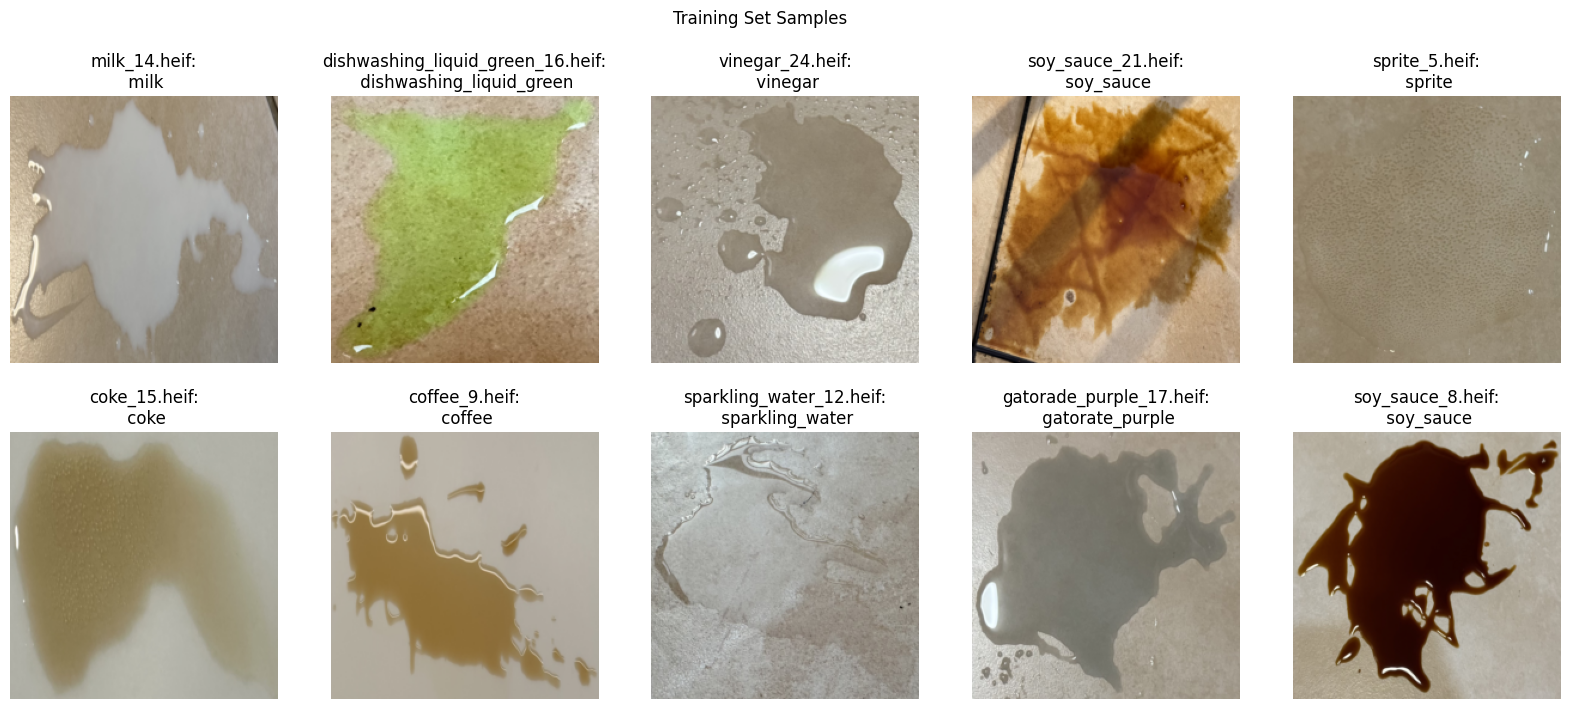

In [10]:
# Visualize samples
visualize_samples(dataset=train_dataset, num_samples=10, title='Training Set Samples')

### **Key Insights**
- Reveals class diversity and potential challenges:
  - Varying lighting conditions
  - Different spill scales/angles
  - Potential occlusion cases
- Normalization appears effective (proper intensity ranges)
- Bounding box implementation verified through visual inspection

## Pre-trained Model Selection

I have selected two widely-used pretrained CNN architectures for this classification task:

- **VGG16**: I chose this model for its simplicity, ease of interpretation, and historical success in standard image classification tasks. It is known for its simplicity, straightforward structure, and decent performance on image classification tasks.
- **ResNet50**: I selected this model primarily for its deeper architecture with residual connections, enabling effective training of deeper networks. Residual connections mitigate the vanishing gradient problem, making it more suitable for complex fine-grained classification tasks.

Both models are pretrained on ImageNet, providing a strong initialization point for fine-tuning on our spills dataset.

### Data Augmentation and Transformation

Data augmentation helps prevent model overfitting and improves generalization by artificially increasing dataset size and variety. We apply strong data augmentation techniques including:

- Random rotation and flipping
- Random resized cropping
- Color jittering (brightness, contrast, saturation, hue changes)

In [11]:
import os
import time
import copy
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# ============================
# Training Configuration
# ============================
DATA_PATH = './data'
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 32
NUM_EPOCHS = 20

# Define image transformation pipelines
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [12]:
# Create training, validation, testing datasets
train_dataset = SpillsDataset(
    root=DATA_PATH,
    mode="train",
    transform=train_transform,
    bounding_box_crop=True,   # if you want bounding box usage
    split_ratios=(0.6, 0.1, 0.3),
    random_seed=42
)

val_dataset = SpillsDataset(
    root=DATA_PATH,
    mode="val",
    transform=test_transform,
    bounding_box_crop=True,
    split_ratios=(0.6, 0.1, 0.3),
    random_seed=42
)

test_dataset = SpillsDataset(
    root=DATA_PATH,
    mode="test",
    transform=test_transform,
    bounding_box_crop=True,
    split_ratios=(0.6, 0.1, 0.3),
    random_seed=42
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Length of Training Set:\t\t{len(train_dataset)}")
print(f"Length of Validation Set:\t{len(val_dataset)}")
print(f"Length of Testing Set:\t\t{len(test_dataset)}")

Length of Training Set:		329
Length of Validation Set:	56
Length of Testing Set:		165


## Model Implementation and Fine-tuning

I leveraged pre-trained CNN models by replacing the final classification layers to match our dataset categories. I have used `Adam` optimizer and `CrossEntropyLoss` criterion for training, and popular learning rate of $1e-4$ to ensure stable fine-tuning, preventing rapid divergence or oscillations.

In [13]:
def create_model(model, num_classes):
    """
    Returns a pretrained model with final layer replaced
    to match the number of classes in your dataset.
    """
    if model.lower()=='vgg':
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # The classifier part is a series of Linear layers. The last Linear layer has 1000 outputs for ImageNet.
        # So replace the last layer to have `num_classes`.
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    elif model.lower()=='resnet':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        # Replace the final FC layer (model.fc) to match num_classes
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    return model


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """
    Train a model with optional validation. Returns the best model weights and training history.
    """
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # print(f"Epoch {epoch+1}/{num_epochs}")
        # print("-"*10)
        start_time = time.time()

        # 1. Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_epoch_loss = running_loss / total
        train_epoch_acc = 100.0 * correct / total

        # 2. Validation Phase
        val_epoch_loss, val_epoch_acc = evaluate_model(model, val_loader, criterion, device)

        # Track best accuracy
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_weights = copy.deepcopy(model.state_dict())

        # Save metrics
        history['train_loss'].append(train_epoch_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_acc:.2f}%")
        print(f"Val   Loss: {val_epoch_loss:.4f},   Val Accuracy: {val_epoch_acc:.2f}%")
        print("-" * 50)
        
    print("Training complete.")
    print(f"Best validation accuracy: {best_acc:.2f}%")

    model.load_state_dict(best_weights)  # load best weights
    return model, history


In [15]:
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluate model on a given data loader. Returns (loss, accuracy).
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating..."):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


In [16]:
NUM_CLASSES = len(train_dataset.classes)
print(f"The number of class labels in the dataset: {NUM_CLASSES}")

vgg_model = create_model(model='VGG', num_classes=NUM_CLASSES)
resnet_model = create_model(model='ResNet', num_classes=NUM_CLASSES)

The number of class labels in the dataset: 22


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 212MB/s] 
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


In [17]:
criterion = nn.CrossEntropyLoss()

vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

In [18]:
print("==================== Training VGG16 ====================")
vgg_model, vgg_history = train_model(
    vgg_model,
    train_loader,
    val_loader,
    criterion,
    vgg_optimizer,
    num_epochs=NUM_EPOCHS
)

==================== Training VGG16 ====================


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.82s/it]


Epoch 1/20 | Time: 76.23s
Train Loss: 3.0732, Train Accuracy: 9.12%
Val   Loss: 2.8171,   Val Accuracy: 26.79%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.91s/it]


Epoch 2/20 | Time: 86.36s
Train Loss: 2.4903, Train Accuracy: 28.88%
Val   Loss: 1.9457,   Val Accuracy: 44.64%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.70s/it]


Epoch 3/20 | Time: 88.03s
Train Loss: 1.7820, Train Accuracy: 44.68%
Val   Loss: 1.4908,   Val Accuracy: 55.36%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.56s/it]


Epoch 4/20 | Time: 86.31s
Train Loss: 1.3525, Train Accuracy: 58.05%
Val   Loss: 1.1118,   Val Accuracy: 67.86%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.83s/it]


Epoch 5/20 | Time: 85.73s
Train Loss: 1.1455, Train Accuracy: 59.88%
Val   Loss: 0.8447,   Val Accuracy: 76.79%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


Epoch 6/20 | Time: 85.13s
Train Loss: 0.9262, Train Accuracy: 69.91%
Val   Loss: 0.9522,   Val Accuracy: 73.21%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.58s/it]


Epoch 7/20 | Time: 85.29s
Train Loss: 0.6866, Train Accuracy: 76.90%
Val   Loss: 0.9306,   Val Accuracy: 66.07%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


Epoch 8/20 | Time: 85.68s
Train Loss: 0.5873, Train Accuracy: 82.37%
Val   Loss: 0.7584,   Val Accuracy: 76.79%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.58s/it]


Epoch 9/20 | Time: 86.28s
Train Loss: 0.4409, Train Accuracy: 88.15%
Val   Loss: 0.7650,   Val Accuracy: 85.71%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.66s/it]


Epoch 10/20 | Time: 86.62s
Train Loss: 0.3575, Train Accuracy: 89.97%
Val   Loss: 1.1803,   Val Accuracy: 82.14%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


Epoch 11/20 | Time: 85.97s
Train Loss: 0.2689, Train Accuracy: 91.19%
Val   Loss: 1.1315,   Val Accuracy: 75.00%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


Epoch 12/20 | Time: 85.85s
Train Loss: 0.3144, Train Accuracy: 92.40%
Val   Loss: 1.3691,   Val Accuracy: 75.00%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.58s/it]


Epoch 13/20 | Time: 87.21s
Train Loss: 0.2472, Train Accuracy: 90.88%
Val   Loss: 0.9152,   Val Accuracy: 80.36%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


Epoch 14/20 | Time: 86.35s
Train Loss: 0.1707, Train Accuracy: 95.44%
Val   Loss: 0.9826,   Val Accuracy: 82.14%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.55s/it]


Epoch 15/20 | Time: 85.77s
Train Loss: 0.1346, Train Accuracy: 96.05%
Val   Loss: 1.1184,   Val Accuracy: 80.36%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


Epoch 16/20 | Time: 87.06s
Train Loss: 0.3068, Train Accuracy: 92.10%
Val   Loss: 0.9200,   Val Accuracy: 78.57%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


Epoch 17/20 | Time: 87.24s
Train Loss: 0.3137, Train Accuracy: 90.88%
Val   Loss: 0.7452,   Val Accuracy: 85.71%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:12<00:00,  6.50s/it]


Epoch 18/20 | Time: 85.86s
Train Loss: 0.1062, Train Accuracy: 96.96%
Val   Loss: 0.9421,   Val Accuracy: 75.00%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.51s/it]


Epoch 19/20 | Time: 85.74s
Train Loss: 0.1217, Train Accuracy: 96.96%
Val   Loss: 0.7819,   Val Accuracy: 83.93%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.68s/it]

Epoch 20/20 | Time: 84.87s
Train Loss: 0.1309, Train Accuracy: 95.74%
Val   Loss: 0.9784,   Val Accuracy: 82.14%
--------------------------------------------------
Training complete.
Best validation accuracy: 85.71%


In [19]:
print("==================== Training ResNet50 ====================")
resnet_model, resnet_history = train_model(
    resnet_model,
    train_loader,
    val_loader,
    criterion,
    resnet_optimizer,
    num_epochs=NUM_EPOCHS
)

==================== Training ResNet50 ====================


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.99s/it]


Epoch 1/20 | Time: 88.01s
Train Loss: 3.0295, Train Accuracy: 16.11%
Val   Loss: 2.9429,   Val Accuracy: 25.00%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.76s/it]


Epoch 2/20 | Time: 87.81s
Train Loss: 2.8421, Train Accuracy: 38.91%
Val   Loss: 2.7374,   Val Accuracy: 42.86%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.71s/it]


Epoch 3/20 | Time: 88.63s
Train Loss: 2.5578, Train Accuracy: 56.23%
Val   Loss: 2.3661,   Val Accuracy: 62.50%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  7.00s/it]


Epoch 4/20 | Time: 88.53s
Train Loss: 2.1426, Train Accuracy: 65.35%
Val   Loss: 1.8542,   Val Accuracy: 60.71%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.98s/it]


Epoch 5/20 | Time: 88.13s
Train Loss: 1.7060, Train Accuracy: 74.47%
Val   Loss: 1.4693,   Val Accuracy: 62.50%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.84s/it]


Epoch 6/20 | Time: 90.28s
Train Loss: 1.3110, Train Accuracy: 77.81%
Val   Loss: 1.1904,   Val Accuracy: 75.00%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.86s/it]


Epoch 7/20 | Time: 89.68s
Train Loss: 1.0477, Train Accuracy: 77.51%
Val   Loss: 0.9378,   Val Accuracy: 80.36%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.98s/it]


Epoch 8/20 | Time: 89.65s
Train Loss: 0.7744, Train Accuracy: 83.59%
Val   Loss: 0.7716,   Val Accuracy: 82.14%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


Epoch 9/20 | Time: 87.28s
Train Loss: 0.5918, Train Accuracy: 88.75%
Val   Loss: 0.6502,   Val Accuracy: 87.50%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.75s/it]


Epoch 10/20 | Time: 87.72s
Train Loss: 0.4642, Train Accuracy: 91.19%
Val   Loss: 0.5015,   Val Accuracy: 87.50%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.78s/it]


Epoch 11/20 | Time: 89.03s
Train Loss: 0.3133, Train Accuracy: 96.05%
Val   Loss: 0.4258,   Val Accuracy: 89.29%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:14<00:00,  7.09s/it]


Epoch 12/20 | Time: 88.64s
Train Loss: 0.2657, Train Accuracy: 95.44%
Val   Loss: 0.4290,   Val Accuracy: 89.29%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


Epoch 13/20 | Time: 88.60s
Train Loss: 0.2115, Train Accuracy: 96.66%
Val   Loss: 0.3690,   Val Accuracy: 89.29%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]


Epoch 14/20 | Time: 89.06s
Train Loss: 0.1486, Train Accuracy: 98.48%
Val   Loss: 0.3801,   Val Accuracy: 89.29%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


Epoch 15/20 | Time: 89.40s
Train Loss: 0.1341, Train Accuracy: 97.57%
Val   Loss: 0.3012,   Val Accuracy: 94.64%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:14<00:00,  7.09s/it]


Epoch 16/20 | Time: 89.58s
Train Loss: 0.0934, Train Accuracy: 99.09%
Val   Loss: 0.3389,   Val Accuracy: 87.50%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.83s/it]


Epoch 17/20 | Time: 89.02s
Train Loss: 0.0930, Train Accuracy: 99.09%
Val   Loss: 0.2909,   Val Accuracy: 92.86%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


Epoch 18/20 | Time: 89.49s
Train Loss: 0.0802, Train Accuracy: 98.48%
Val   Loss: 0.3340,   Val Accuracy: 91.07%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


Epoch 19/20 | Time: 89.81s
Train Loss: 0.0825, Train Accuracy: 98.48%
Val   Loss: 0.2669,   Val Accuracy: 92.86%
--------------------------------------------------


Evaluating...: 100%|██████████| 2/2 [00:14<00:00,  7.06s/it]

Epoch 20/20 | Time: 89.35s
Train Loss: 0.0485, Train Accuracy: 99.70%
Val   Loss: 0.2825,   Val Accuracy: 92.86%
--------------------------------------------------
Training complete.
Best validation accuracy: 94.64%


## **Evaluating models on Testing Set and Comparison**

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss_vgg, test_acc_vgg = evaluate_model(vgg_model, test_loader, criterion, device)
test_loss_resnet, test_acc_resnet = evaluate_model(resnet_model, test_loader, criterion, device)

print(f"VGG16  Test Loss: {test_loss_vgg:.4f}, Test Accuracy: {test_acc_vgg:.2f}%")
print(f"ResNet Test Loss: {test_loss_resnet:.4f}, Test Accuracy: {test_acc_resnet:.2f}%")


Evaluating...: 100%|██████████| 6/6 [00:39<00:00,  6.56s/it]

VGG16  Test Loss: 0.7614,    Test Accuracy: 73.94%
ResNet Test Loss: 0.4084, Test Accuracy: 84.85%


### Comparative Analysis

| Model    | Best Val Accuracy (%) | Test Loss | Test Accuracy (%) |
|----------|-------------------|-----------|-------------------|
| VGG16    | 85.71             | 0.7614    | 73.94             |
| ResNet50 | **94.64**             | **0.4084**    | **84.85**         |

**Observation:**  
ResNet50 clearly outperformed VGG16, likely benefiting from its deeper architecture and residual connections.

#### **Analysis on Strengths and Weaknesses**
- **VGG16**:   
  - Strengths: Fast initial convergence, lower computational complexity.  
  - Weaknesses: Struggled to differentiate between visually similar spill classes due to limited depth and feature representation power.
- **ResNet50**:  
  - Strengths: Demonstrated superior performance in capturing intricate visual differences, benefiting from deeper architecture and residual learning.  
  - Weaknesses: Slightly higher computational cost, but justified by significant accuracy improvement.
  
> The higher performance of **ResNet50** strongly indicates its suitability for fine-grained classification tasks, reinforcing the importance of model depth and residual learning mechanisms.

## **Visualizing Training History**
Visualizing loss and accuracy curves provided insights into the training dynamics.

In [21]:
def plot_history(history, title="Training History"):
    """
    Plot training and validation metrics.
    
    Args:
        history: Dictionary containing metrics
        title: Title for the plot
    """
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(12,5))
    plt.suptitle(title)

    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

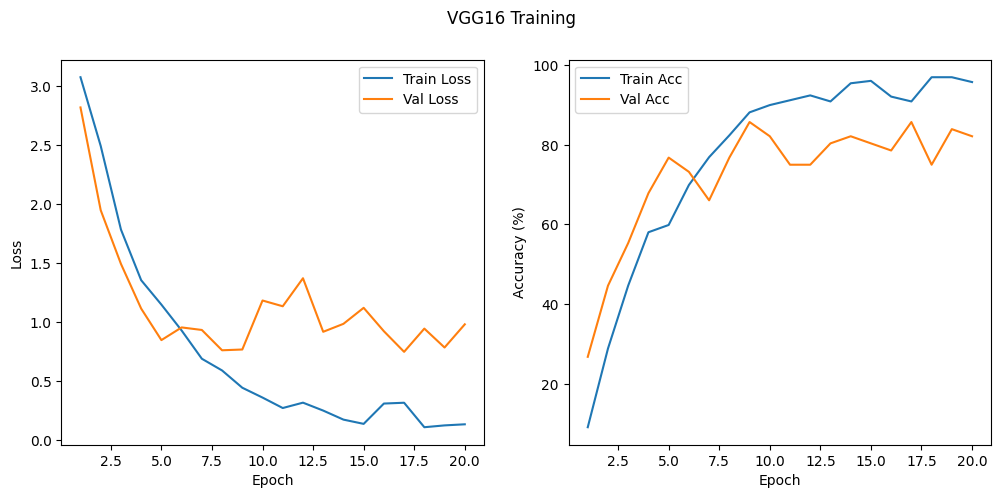

In [22]:
# Plot for VGG16 model
plot_history(vgg_history, "VGG16 Training")


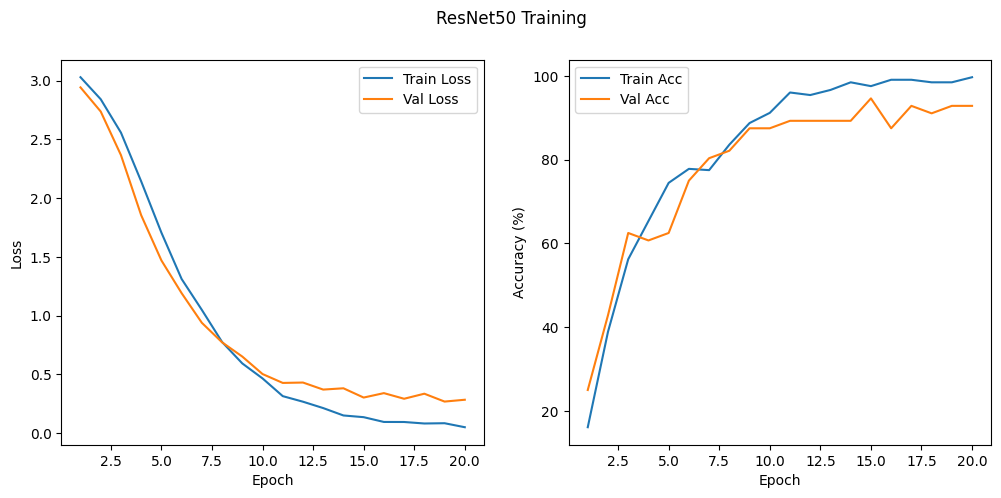

In [23]:
# Plot for ResNet50 model
plot_history(resnet_history, "ResNet50 Training")

### **Observations**
- **ResNet50** showed a smoother convergence pattern with higher final accuracy. This model has better generalization and capacity to capture subtle distinctions among spill types.
- **VGG16** reached moderate accuracy quickly but did not improve significantly thereafter. This confirms its limited capacity to improve further.

## **Visualization of Misclassified Images**
Visualizing misclassified images helps to:

- **Understand model errors**: Identify specific categories or visual conditions causing misclassifications.
- **Inform improvements**: Guide further tuning and identify the need for additional data collection or augmentation.


In [29]:
def visualize_misclassifications(model, dataloader, dataset, device, num_images=6, title='Misclassified Images'):
    """
    Visualizes misclassified images by a given model.

    Args:
        model (torch.nn.Module): Trained CNN model.
        dataloader (DataLoader): DataLoader for test data.
        dataset (Dataset): Dataset instance (for label mapping).
        device (torch.device): Device (CPU/GPU).
        num_images (int): Number of misclassified images to visualize.
        title (str): Title for visualization.
    """
    model.eval()
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    # Gather misclassified samples
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, true_label in zip(images, preds, labels):
                if pred != true_label:
                    misclassified_images.append(img.cpu())
                    predicted_labels.append(pred.cpu())
                    true_labels.append(true_label.cpu())

                if len(misclassified_images) >= num_images:
                    break
            if len(misclassified_images) >= num_images:
                break

    total_misclassified = len(misclassified_images)
    print(f"==========Visualizing {total_misclassified} misclassified images.==========")

    if total_misclassified == 0:
        print("No misclassified images found!")
        return

    # Set number of images per row
    images_per_row = 5
    rows = int(np.ceil(total_misclassified / images_per_row))

    plt.figure(figsize=(images_per_row * 4, rows * 4))
    
    for idx in range(total_misclassified):
        img = misclassified_images[idx].numpy().transpose((1, 2, 0))
        
        # De-normalize (assuming ImageNet normalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        true_label = dataset.idx_to_class[true_labels[idx].item()]
        pred_label = dataset.idx_to_class[predicted_labels[idx].item()]

        plt.subplot(rows, images_per_row, idx + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color='red')
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

==========Visualizing 10 misclassified images.==========


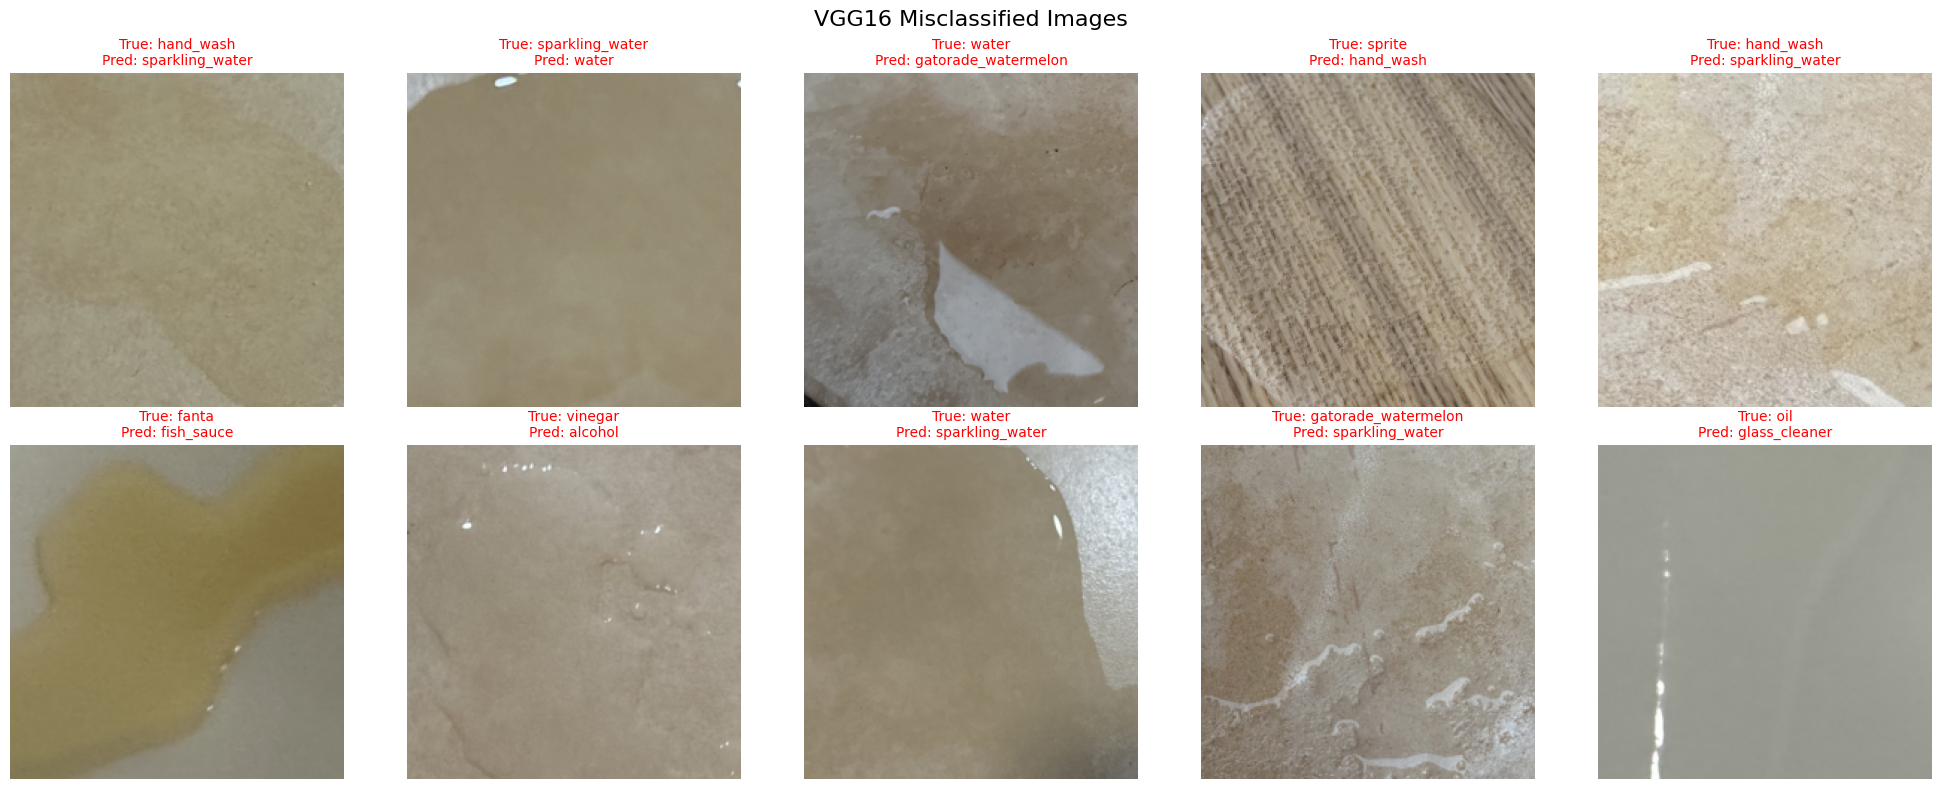

In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize misclassifications by VGG16
visualize_misclassifications(
    model=vgg_model, 
    dataloader=test_loader, 
    dataset=test_dataset,
    device=device,
    num_images=10,
    title='VGG16 Misclassified Images'
)

==========Visualizing 15 misclassified images.==========


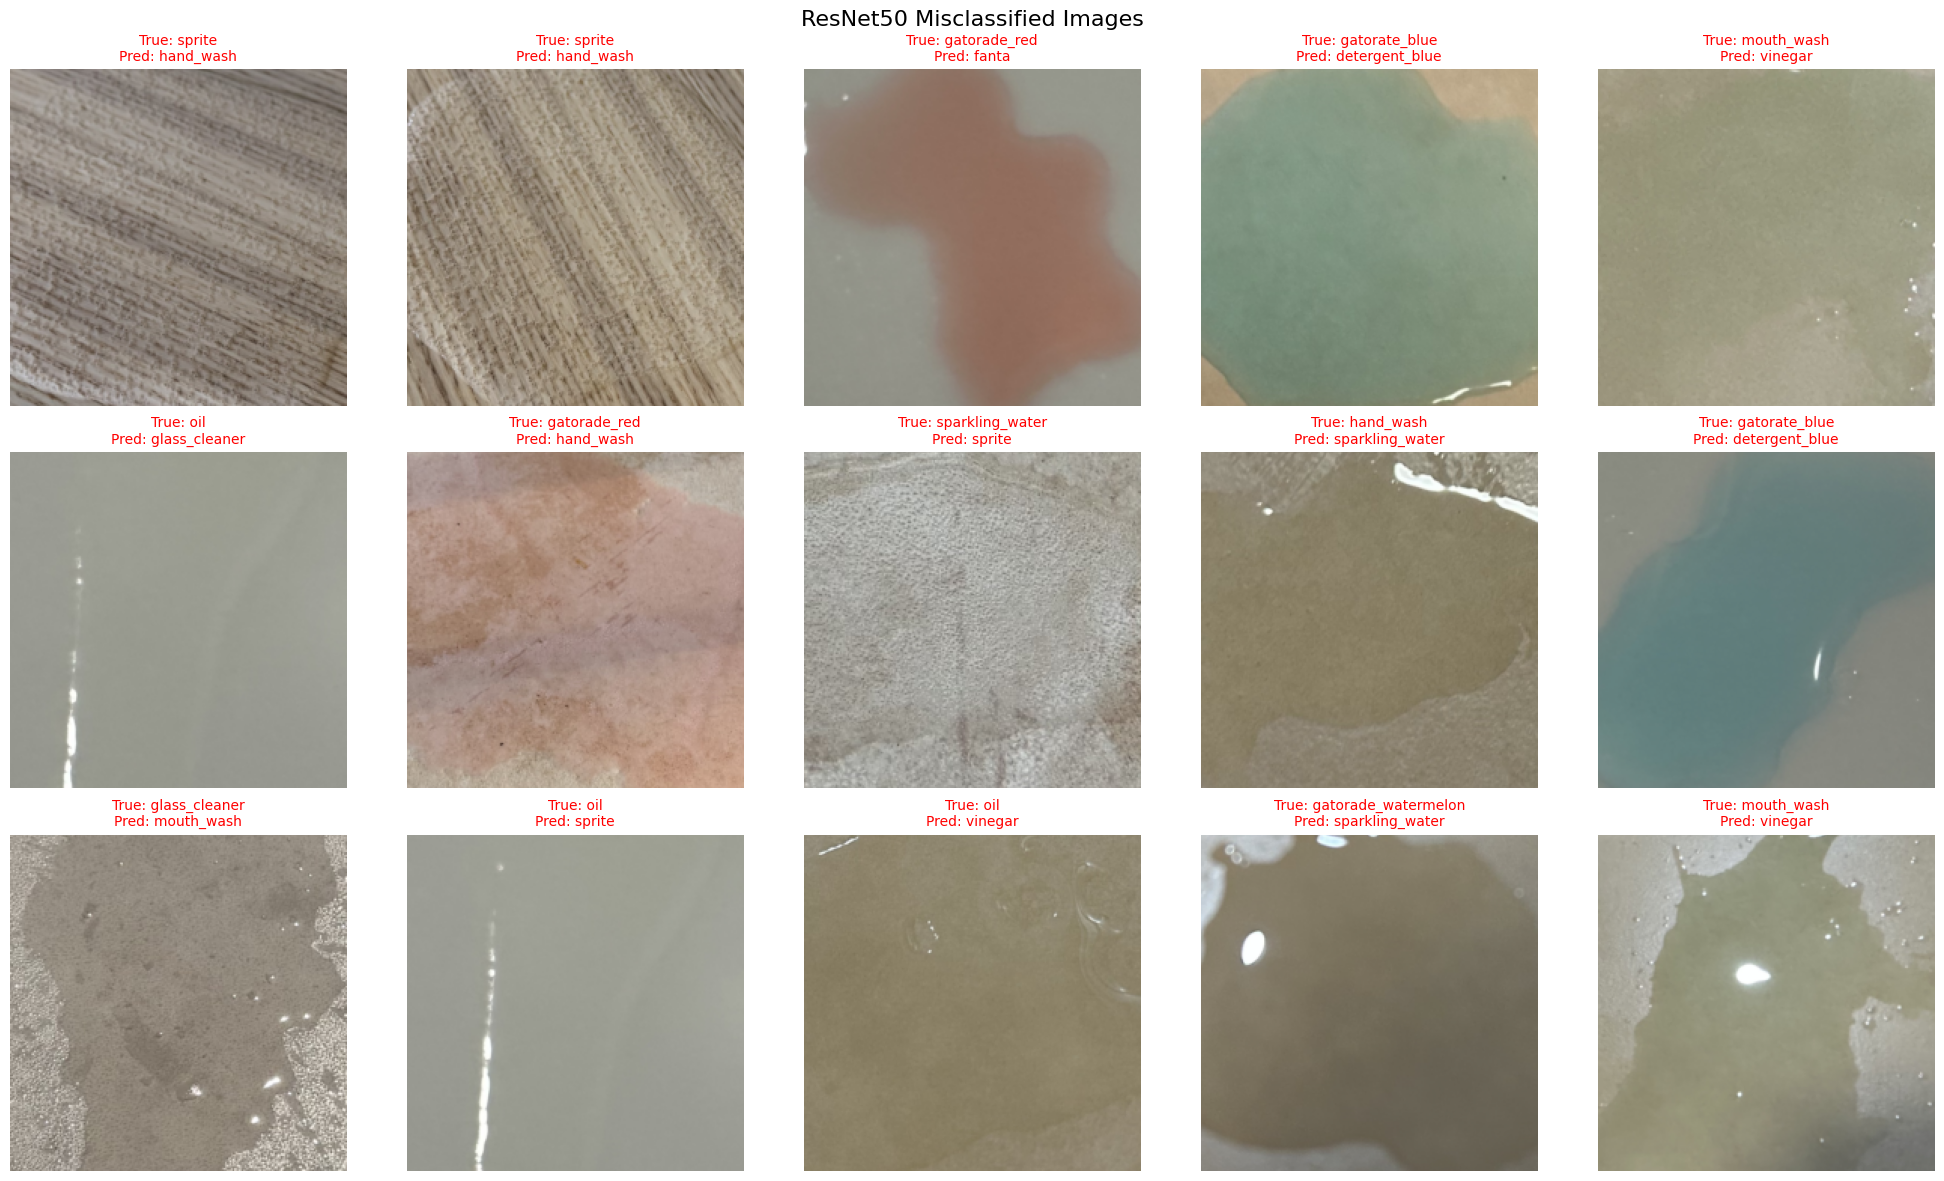

In [32]:
# Visualize misclassifications by ResNet50
visualize_misclassifications(
    model=resnet_model, 
    dataloader=test_loader, 
    dataset=test_dataset,
    device=device,
    num_images=15,
    title='ResNet50 Misclassified Images'
)

### **Misclassification Analysis: Common Patterns and Challenges**

#### **1. High Visual Similarity Between Classes**
- Many spills (e.g., `water`, `sparkling_water`, `vinegar`, `alcohol`) look visually **almost identical**, especially when lighting, background, or angle do not vary much.
- Example:
  - `True: water` → `Pred: sparkling_water`
  - `True: vinegar` → `Pred: alcohol`
  - These liquids are **transparent and colorless**, causing models to struggle even with deep feature representations.

#### **2. Background Texture Influence**
- Some misclassifications seem to be influenced more by **background texture** than the spill.
- Example:
  - `True: sprite` → `Pred: hand_wash` (in VGG16)
  - `True: oil` → `Pred: glass_cleaner` (in ResNet50)
- This suggests the model is possibly extracting **background-dependent features**, rather than spill shape or texture.

#### **3. Poor Differentiation Among Gatorade Variants**
- Models struggle with **gatorade variants**, such as:
  - `gatorade_red` vs. `fanta`
  - `gatorade_watermelon` vs. `sparkling_water`
  - These variants might have subtle differences in hue, but lighting or camera settings (e.g., white balance) can **neutralize those cues**.

#### **4. Slight Color Shifts Causing Confusion**
- Spill categories like `dishwashing_liquid_green`, `glass_cleaner`, and `mouth_wash` are **visually distinct in color**, yet confused by the model when:
  - Color fades due to reflection or ambient lighting.
  - The spill spreads thinly, affecting hue saturation.

### **Challenges in Fine-Grained Classification Observed**

| Challenge | Example | Impact |
|----------|--------|--------|
| **Lack of prominent features** | Transparent or lightly colored spills | Models cannot localize or differentiate spill content reliably |
| **Spill texture similarity** | `oil`, `water`, `sparkling_water` | Surface reflections look similar |
| **Reflection and shadow artifacts** | Seen in many ResNet misclassified cases | Degrades color/shape integrity |
| **Small dataset size** | Limited samples per class | Less generalization in unseen lighting/backgrounds |

> *These insights highlight potential improvements, such as targeted data augmentation, more diverse training examples, or even fine-tuning with attention mechanisms for better results.*

## **Conclusions and Future Improvements**

The findings emphasize that deeper CNN architectures (like ResNet50) equipped with residual connections are more appropriate for challenging real-world fine-grained classification tasks, where subtle differences often determine classification outcomes.

### **Summary of Findings**
- **ResNet50** significantly outperformed VGG16 in fine-grained spill classification, highlighting the importance of deeper, residual networks.
- Data augmentation methods substantially improved model robustness and accuracy, indicating their critical role in fine-grained image classification.

### **Recommendations for Future Work**
- **Explore Deeper and More Advanced Models**: Experimentation with even deeper residual networks (ResNet101, ResNet152) or modern architectures like **EfficientNet**, **Vision Transformer (ViT)**, and **ConvNeXt** could further improve accuracy.
- **Attention Mechanisms**: Integrating attention modules may enhance focus on discriminative image regions crucial for fine-grained classification tasks.